In [1]:
import os
from collections import defaultdict

import pandas as pd 
import numpy as np
from scipy import linalg, stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.covariance import MinCovDet, EllipticEnvelope

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set_style("white")

In [2]:
from scipy.linalg import svd, svdvals

#### Read the dataset

In [4]:
df = pd.read_parquet('../data/datasetForPLS-DA.parquet')
dfContr = df[df['batch_id'].isin(['DMSO', 'non-inf'])].copy() # select wells with DMSO in infected and noninfected cells
dfContr.reset_index(inplace=True, drop=True)

#### Define the functions to perform whitening and compute Mahalanobis distance

**Whitening** is a transformation that takes the distribution of Healthy cells and maps them to such space that
1. has orthogonal directions – each feature is uncorrelated with others,
2. these directions span the most of the covariance – they capture the scattering of Healthy cells best,
3. new space has lower dimension - we can drop those orthogonal directions that span too little information (same as in PCA),
4. orthogonal directions are standartized – the scattering of Healthy cells becomes uniform along each direction; hence each feauture impacts our distance equally.

**Mahalanobis distance** = Ordinary Euclidean distance computed after whitening transformation

In [5]:
def compute_whitening_transform(cells, rank=None):
    cov_matrix = np.cov(cells, rowvar=False)
    sigma, u = linalg.eigh(cov_matrix, check_finite=True)
    descending_idx = sigma.argsort()[::-1]
    sigma = sigma[descending_idx]
    u = u[:, descending_idx]
    
    if rank is None:
        eps = np.finfo(u.dtype.char.lower()).eps
        rtol = np.max(np.abs(sigma)) * max(cov_matrix.shape) * eps
        cutoff = (abs(sigma) > rtol)
        rank = np.sum(cutoff)
    else:
        cutoff = (sigma > 0.)
        rank = min(np.sum(cutoff), rank)
    
    psigma_diag = 1.0 / sigma[:rank]
    whitening_transform = np.diag(np.sqrt(psigma_diag)) @ u.T[:rank, :]
    return whitening_transform, rank


def compute_whitening_transform_robust(cells, rank=None):
    u, sigma, vt = linalg.svd(cells - np.mean(cells, axis=0), check_finite=True)
    descending_idx = sigma.argsort()[::-1]
    sigma = sigma[descending_idx]
    u = u[:, descending_idx]
    vt = vt[descending_idx, :]

    if rank is None:
        eps = np.finfo(u.dtype.char.lower()).eps
        rtol = np.max(np.abs(sigma)) * max(cov_matrix.shape) * eps
        cutoff = (abs(sigma) > rtol)
        rank = np.sum(cutoff)
    else:
        cutoff = (sigma > 0.)
        rank = min(np.sum(cutoff), rank)
    cells = u[:, :rank] @ np.diag(sigma[:rank]) @ vt[:rank, :]

    cov_matrix = MinCovDet().fit(cells).covariance_
    whitening_transform = linalg.inv(whitening_transform)
    return whitening_transform, rank


def get_distance(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    return distance


def get_distance_deviation(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    chi_squared_mode = n_components - 2
    deviation = distance - np.sqrt(chi_squared_mode)
    return deviation


def get_proba(healthy_cells, cells, n_components=None, robust=False):
    if robust:
        whitening_transform, n_components = compute_whitening_transform_robust(healthy_cells, rank=n_components)
    else:
        whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)

    whitening_transform, n_components = compute_whitening_transform(healthy_cells, rank=n_components)
    healthy_mean = np.mean(healthy_cells, axis=0)
    delta = (cells - healthy_mean).T
    delta = whitening_transform @ delta
    distance = np.linalg.norm(delta, ord=2, axis=0)
    proba = 1 - stats.chi2.cdf(distance**2, df=n_components)
    return proba



#### Selecting effective dimension

(by looking at the singular values from PCA)

In [6]:
# There are some methods in literature that allow to automatically select the optimal number of components from PCA
# We employ one such method below

def svht(X, sigma=None):
    """
    Return the optimal singular value hard threshold (SVHT) value from [1].
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Implementation from [2].
    [1] Gavish, Matan, and David L. Donoho. “The optimal hard threshold for singular values is.” IEEE Transactions on Information Theory 60.8 (2014): 5040-5053.
    [2] Robert Taylor. "Optimal Singular Value Hard Threshold." https://humaticlabs.com/blog/optimal-svht/.
    """

    def omega_approx(beta):
        '''Return an approximate omega value for given beta. Equation (5) from Gavish 2014.'''
        return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

    def lambda_star(beta):
        '''Return lambda star for given beta. Equation (11) from Gavish 2014.'''
        return np.sqrt(2 * (beta + 1) + (8 * beta) / 
                    (beta + 1 + np.sqrt(beta**2 + 14 * beta + 1)))
    
    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

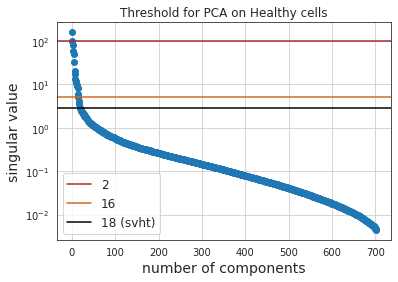

In [7]:
df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()

cov_matrix = np.cov(x_healthy, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_healthy.shape) - 1
sigma = sigma[::-1]
plt.scatter(range(rank), sigma[:rank])

n_components = 2
plt.axhline(sigma[n_components - 1], c='brown', label=n_components)

n_components = np.count_nonzero(sigma > 5)
plt.axhline(sigma[n_components - 1], c='chocolate', label=n_components)

# optimal threshold for PCA of Healthy cells
tau = svht(x_healthy)
plt.axhline(sigma[int(tau)], c='k', label=f'{int(tau)} (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on Healthy cells")
plt.show()

#### Computing predictions: PLS-DA, correlations, and Mahalanobis distance

In [8]:
x_all = df.iloc[:, 7:].copy()
clip = 50 # if we want to clip eventual extreme values; otherwise float('inf')
x_all.clip(lower=-clip, upper=clip, inplace=True)

#### PLS-DA allows to identify the drugs with too low effect – by comparing positive and negative control (non-infectected vs DMSO)

In [9]:
# PLS predictions
x = dfContr.iloc[:,7:]
x.clip(lower=-clip, upper=clip, inplace=True)
y = np.where(dfContr['pert_type'] == 'negcon', 0, 1)
pls = PLSRegression(n_components=2, scale=False)
pls.fit(x, y)
pls_pred = pls.predict(x_all)
pls_pred = pd.DataFrame(pls_pred, columns=['pls'])

Illustration for PLS-DA: non-infected, DMSO, and Remdesevir at different concentrations

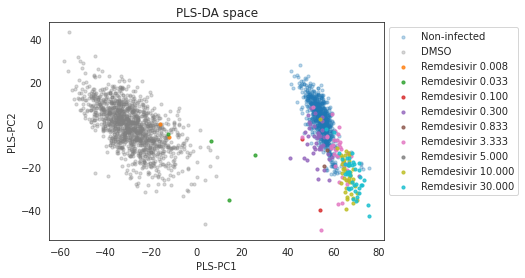

In [12]:
x_pls = pls.transform(x_all)

batch_names = {
    'DMSO': 'DMSO', 
    'non-inf': 'Uninfected', 
    'DD4386006': 'Remdesivir'
}
conc_list = sorted(set([float(conc.split('_')[-1]) for conc in df['comp_conc']]))

# Non-infected
non_inf = df['batch_id'] == 'non-inf'
non_inf_points = x_pls[non_inf].T
plt.scatter(non_inf_points[0], non_inf_points[1], label='Non-infected', s=10, alpha=0.3)

# DMSO (no treatment effect)
dmso = df['batch_id'] == 'DMSO'
dmso_points = x_pls[dmso].T
plt.scatter(dmso_points[0], dmso_points[1], label='DMSO', s=10, alpha=0.3, color='gray')

# Remdesivir
for conc in conc_list:
    points = x_pls[df['comp_conc'] == f"DD4386006_{conc}"].T
    plt.scatter(points[0], points[1], label=f"Remdesivir {float(conc):.3f}", s=10, alpha=0.8)
    
plt.xlabel("PLS-PC1")
plt.ylabel("PLS-PC2")
plt.title("PLS-DA space")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Correlations between cells treated by differend compounds and Healthy cells

In [13]:
# Correlations
df_grouped = df.groupby(['comp_conc']).mean(numeric_only=True)
corr_matr = df_grouped.iloc[:, 3:].T.corr()
corr_pred = corr_matr.loc[: , 'non-inf_0.3']

#### Whitening and Mahalanobis distance

In [14]:
# Predictions based on whitening transform
n_components = 18
# Distance to Healthy (Mahalanobis)
df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()
dist_pred = get_distance(x_healthy, x_all, n_components=n_components)
dist_pred = pd.DataFrame(dist_pred, columns=['distance'])
# Probability of Healthy
proba_pred = get_proba(x_healthy, x_all, n_components=n_components)
proba_pred = pd.DataFrame(proba_pred, columns=['proba'])

#### Concatenate all predictions


In [15]:
predictions = pd.concat([df.iloc[:, :7], pls_pred, corr_pred, dist_pred, proba_pred], axis=1)
predictions.to_csv('output/Predictions.csv', sep=';')

#### Ranking for all compounds at different concentrations - averaged over replicates


In [16]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'batch_id', 'cmpd_conc', 'Count_nuclei', 
    'pls', 
    'distance',
    # 'proba',
]]
# Aggregate replicates
average_predictions = selected_columns.groupby(by=['batch_id', 'cmpd_conc'], as_index=False).agg({
        'Count_nuclei': 'median', 
        'pls': [quantile(.25), quantile(.75), 'median'],
        'distance': [quantile(.25), quantile(.75), 'median'],
        # 'proba': 'median',
})
# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns

# Add predictions based on correlation with Healthy
average_predictions.insert(6, 'corr', corr_pred.values)

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

average_predictions.reset_index(inplace=True, drop=True)
average_predictions.to_csv("output/Predictions.csv", sep=';')
average_predictions.head(20)

,batch_id,cmpd_conc,Count_nuclei_median,pls_q_25,pls_q_75,pls_median,corr,distance_q_25,distance_q_75,distance_median
0,non-inf,0.300000,307.00,0.954188,1.006469,0.983199,1.000000,3.362322,4.600327,3.858445
1,DO8167002,0.833333,300.50,0.926838,0.985911,0.956375,0.981976,3.836471,4.033751,3.935111
2,DO8167002,10.000000,289.50,0.938701,0.983830,0.965922,0.991753,3.735381,4.899216,4.118547
3,DO8167002,3.333333,295.25,0.903253,0.992483,0.959236,0.990396,3.635612,5.263111,4.162268
4,DI1202001,3.333333,291.50,0.912297,0.958339,0.932826,0.988545,3.634499,5.247782,4.276881
5,DO8167002,30.000000,289.00,0.936139,0.991036,0.962468,0.990095,3.815498,5.113020,4.568228
6,DI1202001,10.000000,299.50,0.944578,1.003045,0.970137,0.991391,4.434039,5.190366,4.687156
7,DD4386006,0.300000,290.75,0.869676,0.930846,0.908579,0.976340,4.362398,5.628103,4.729768
8,BJ1895621,10.000000,277.00,0.811092,0.871468,0.820551,0.880684,5.171403,7.150777,5.192341
9,BJ1898414,3.333333,264.00,0.657587,0.747457,0.679770,0.689615,5.042438,6.841240,5.339885


**Note**: after the whitening, the squared distance is distributed as a chi-squared random variable – $\chi^2_d$, where $d$ is the selected effective dimension. We can use to test compunds against confidence intervals of this distribution.

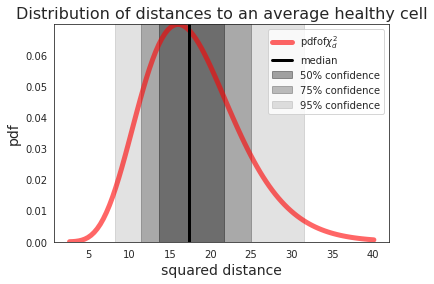

In [18]:
x = np.linspace(stats.chi2.ppf(1e-5, df=n_components), stats.chi2.ppf(1-2e-3, df=n_components), 100)
pdf = stats.chi2.pdf(x, df=n_components)
plt.plot(x, pdf, 'r-', lw=5, alpha=0.6, label=r'$\mathrm{pdf of } \chi^2_d$')
plt.axvline(stats.chi2.median(df=n_components), label='median', c='k', lw=3)
# plt.axvline(n_components - 2, label='mode', c='brown', lw=3)
for conf in (0.5, 0.75, 0.95):
    left, right = stats.chi2.interval(conf, df=n_components)
    plt.fill_betweenx(y=np.linspace(-1, 0.1, 2), x1=left, x2=right, label=f'{conf*100:.0f}% confidence',
                      color='k', alpha=0.5*(1-conf)**0.5)
plt.legend()
plt.ylim(0, max(pdf))
plt.xlabel("squared distance", fontsize=14)
plt.ylabel("pdf", fontsize=14)
plt.title("Distribution of distances to an average healthy cell",  fontsize=16)
plt.show()

Hence, we can rank drugs based on the following: does the distance from a treated cell to an average healthy cell fall into the confidence interval? Furthermore, we can look at this criterion at different concentrations.

Below is the distance vs concentration plot. Three drugs are depicted with errorbars – median distance and 25%-75% quantiles. At the bottom we have the median distance for Healthy cells and its confidence intervals (50%, 75%, and 95%).

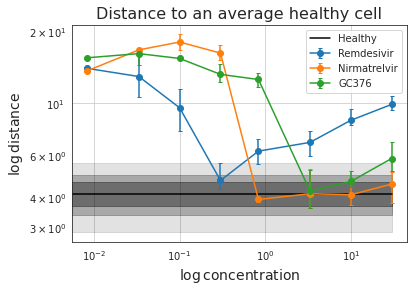

In [20]:
# Map drug IDs to drug names (is it correct?)
drug_names = {
    'DD4386006': 'Remdesivir',
    'DO8167002': 'Nirmatrelvir', 
    'DI1202001': 'GC376',
    # 'BJ1894069': 'BJ1894069',
}

# Drugs - statistics from experimental results
for drug_id, drug_name in drug_names.items():
    drug = average_predictions[average_predictions['batch_id'] == drug_id].sort_values(by=['cmpd_conc'], ascending=True)
    conc = drug['cmpd_conc']
    median = drug['distance_median']
    perc_25 = drug['distance_q_25']
    perc_75 = drug['distance_q_75']
    # Plot option 1: errorbars
    plt.errorbar(conc, median, yerr=[median - perc_25, perc_75 - median], 
                 capsize=2, elinewidth=1.5, fmt='o-', label=drug_name)
    # # Plot option 2: curve and plus-minus regions
    # plt.plot(conc, median, label=drug_name, marker='o')
    # plt.fill_between(conc, perc_25, perc_75, alpha=0.3, zorder=2)


# Healthy cells - confidence intervals
non_inf = average_predictions[average_predictions['batch_id'] == 'non-inf']
conc = range(0, 31, 1)
# mode = max(n_components - 2, 0)
median = n_components * (1 - 2 / (9 * n_components))**3
plt.plot(conc, [np.sqrt(median)] * len(conc), color='k', label='Healthy')
for conf in [0.5, 0.75, 0.95]:
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    plt.fill_between(conc, np.sqrt(left), np.sqrt(right), 
                     color='k', alpha=0.5*(1-conf)**0.5, 
                     zorder=1
                    )

plt.legend()
plt.grid()
# plt.xlabel("concentration", fontsize=14)
plt.xscale('log')
plt.xlabel(r"$\log \mathrm{concentration}$", fontsize=14)

# plt.ylabel("distance", fontsize=14)
plt.yscale('log') 
plt.ylabel(r"$\log \mathrm{distance}$", fontsize=14)

plt.title("Distance to an average healthy cell", fontsize=16)
plt.show()

Using this plot, we can rank these three drugs differently:
1. We can say that Remdesivir is the best because it requires the smallest concentration to hit the confidence interval – that is, get closer to the distribution of Healthy cells.
2. Or we can say that Nirmatrelvir is the best as it stays close to the Healthy cells within a larger interval of different concentrations.

Below, we create the table that would store this information: 
- number of concentration points for each compound that fall into the confidence interval,
- the least concentration that falls into the specified confidence interval.

#### Final ranking

As the final step, we create the per compound ranking as follows:
1. we filter out compounds at such concentrations that have no effect compared to DMSO, based on PLS-DA;
2. we sort compounds starting from those that require the smallest concentration to get close to the Healthy cells (i.e., get into the confidence interval for the distances);
3. if the compounds have the same smallest concentration from 2., we do the remaining sorting based on the minimal distance achieved by all concentrations for the given compound.

In [21]:
# Drop the row for non-infected
non_inf = average_predictions[average_predictions['batch_id'] == 'non-inf']
average_predictions_ = average_predictions.drop(non_inf.index)

# Filter out compounds with a too weak effect based on PLS
no_action = average_predictions_[average_predictions_['pls_median'] < 0.7]
average_predictions_.drop(no_action.index, inplace=True)

# And now we rank using other predictions
predictions_per_cmpd = average_predictions_[['batch_id', 'cmpd_conc', 'Count_nuclei_median', 'distance_median', 'corr']].copy()

def least_conc_hit(condition):
    def least_conc_hit_(conc):
        conc_hits = conc[condition.loc[conc.index]]
        if len(conc_hits) != 0:
            return min(conc_hits)
        else:
            return np.nan
    return least_conc_hit_

# Confidence levels to consider for the distribution of Healthy cells
confidence_levels = [0.95, 0.99, 0.999]
# Select a level for which we find the least concentration that hits it
confidence_hit = 0.999

# Create mask: falls into Healthy confidence intervals
for conf in confidence_levels:
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    predictions_per_cmpd[f'in_{conf}'] = predictions_per_cmpd['distance_median'].between(left**0.5, right**0.5)

grouped = predictions_per_cmpd.groupby(by='batch_id')
predictions_per_cmpd = grouped.agg({ # aggregate compounds across concentrations by 
    # max correlation
    'corr': 'max',
    # min distance to Healthy
    'distance_median': 'min',
    # number of concentrations that fall into Healthy confidence intervals
    **{f'in_{conf}': 'sum' for conf in confidence_levels},
    # least concentration that falls into Healthy confidence interval
    'cmpd_conc': least_conc_hit(predictions_per_cmpd[f'in_{confidence_hit}']),
})

# Sort by 1. the least concentration that hit Healthy confidence intervals, then 2. distance
predictions_per_cmpd.sort_values(by=['cmpd_conc', 'distance_median'], ascending=True, inplace=True)

# Rename columns to more convinient names
predictions_per_cmpd.rename(columns={'corr': 'corr_max', 'distance_median': 'distance_min', 'cmpd_conc': f'least_conc_hit_{confidence_hit}'}, inplace=True)
predictions_per_cmpd.reset_index(inplace=True)

predictions_per_cmpd.to_csv("output/Predictions_per_compound.csv", sep=';')
predictions_per_cmpd.head(55)

,batch_id,corr_max,distance_min,in_0.95,in_0.99,in_0.999,least_conc_hit_0.999
0,DD4386006,0.976340,4.729768,1,1,2,0.300000
1,DO8167002,0.991753,3.935111,4,4,4,0.833333
2,DI1202001,0.991391,4.276881,2,3,3,3.333333
3,BJ1896319,0.925731,5.749583,0,1,1,3.333333
4,BJ1898293,0.955633,5.753348,0,1,2,3.333333
5,BJ1894509,0.915058,5.776406,0,1,1,3.333333
6,BJ1895494,0.868927,5.841318,0,1,1,3.333333
7,BJ1895862,0.906159,5.892800,0,1,1,3.333333
8,BJ1894156,0.935319,6.035302,0,1,1,3.333333
9,BJ1895920,0.921643,6.312960,0,0,1,3.333333


We get around 25 compounds that have at least one concentration that hit the confidence interval. Let's look at some drugs from this ranking

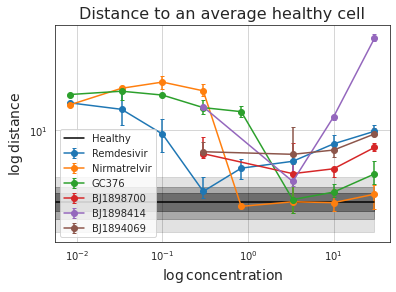

In [24]:
# Map drug IDs to drug names (is it correct?)
drug_names = {
    'DD4386006': 'Remdesivir',
    'DO8167002': 'Nirmatrelvir', 
    'DI1202001': 'GC376',
    'BJ1898700': 'BJ1898700',
    'BJ1898414': 'BJ1898414',
    'BJ1894069': 'BJ1894069',
}

# Drugs - statistics from experimental results
for drug_id, drug_name in drug_names.items():
    drug = average_predictions[average_predictions['batch_id'] == drug_id].sort_values(by=['cmpd_conc'], ascending=True)
    conc = drug['cmpd_conc']
    median = drug['distance_median']
    perc_25 = drug['distance_q_25']
    perc_75 = drug['distance_q_75']
    # Plot option 1: errorbars
    plt.errorbar(conc, median, yerr=[median - perc_25, perc_75 - median], 
                 capsize=2, elinewidth=1.5, fmt='o-', label=drug_name)


# Healthy cells - confidence intervals
non_inf = average_predictions[average_predictions['batch_id'] == 'non-inf']
conc = range(0, 31, 1)
median = n_components * (1 - 2 / (9 * n_components))**3
plt.plot(conc, [np.sqrt(median)] * len(conc), color='k', label='Healthy')
for conf in [0.5, 0.75, 0.95]:
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    plt.fill_between(conc, np.sqrt(left), np.sqrt(right), 
                     color='k', alpha=0.5*(1-conf)**0.5, 
                     zorder=1
                    )

plt.legend()
plt.grid()
plt.xscale('log')
plt.xlabel(r"$\log \mathrm{concentration}$", fontsize=14)

plt.yscale('log') 
plt.ylabel(r"$\log \mathrm{distance}$", fontsize=14)

plt.title("Distance to an average healthy cell", fontsize=16)
plt.show()